In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gpax.supervised_learning.dataset_utils import load_dataset

sns.set_theme()

In [5]:
def dataset_scale_statistics(X, y, dataset_name=None, eps=1e-12):
    """
    Compute Groups 1–3 scale-related statistics for a single dataset.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    dataset_name : str or None
    eps : float, numerical stability

    Returns
    -------
    dict
        Dictionary of computed statistics
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)

    # ----- feature-wise stats -----
    x_std = np.std(X, axis=0, ddof=0)
    x_range = np.ptp(X, axis=0)  # max - min

    # Remove degenerate features safely
    x_std_safe = np.clip(x_std, eps, None)
    x_range_safe = np.clip(x_range, eps, None)

    # ----- target stats -----
    y_std = np.std(y, ddof=0)
    y_range = np.ptp(y)

    stats = {
        "dataset": dataset_name,

        # ===== Group 1: Absolute scale =====
        "x_std_median": np.median(x_std_safe),
        "x_std_max": np.max(x_std_safe),
        "x_range_median": np.median(x_range_safe),
        "x_range_max": np.max(x_range_safe),

        "log10_x_std_median": np.log10(np.median(x_std_safe)),
        "log10_x_std_max": np.log10(np.max(x_std_safe)),
        "log10_x_range_median": np.log10(np.median(x_range_safe)),
        "log10_x_range_max": np.log10(np.max(x_range_safe)),

        "y_std": y_std,
        "y_range": y_range,
        "log10_y_std": np.log10(max(y_std, eps)),
        "log10_y_range": np.log10(max(y_range, eps)),

        # ===== Group 2: Relative x–y scale =====
        "std_y_over_std_x_median": y_std / np.median(x_std_safe),
        "range_y_over_range_x_median": y_range / np.median(x_range_safe),
        "log10_std_y_minus_log10_std_x_median":
            np.log10(max(y_std, eps)) - np.log10(np.median(x_std_safe)),

        # ===== Group 3: Feature scale heterogeneity =====
        "std_ratio_max_min": np.max(x_std_safe) / np.min(x_std_safe),
        "range_ratio_max_min": np.max(x_range_safe) / np.min(x_range_safe),
        "std_coeff_variation": np.std(x_std_safe) / np.mean(x_std_safe),
    }

    return stats

In [7]:
problems = ["chemical_1_tower", "chemical_2_competition", "friction_dyn_one-hot", "friction_stat_one-hot",
            "nasa_battery_1_10min", "nasa_battery_2_20min", "nikuradse_1", "nikuradse_2", "flow_stress_phip0.1", ]
rows = []
for problem in problems:
    X_train, _, y_train, _ = load_dataset(problem, scale_x=False, scale_y=False)
    rows.append(dataset_scale_statistics(X_train, y_train, dataset_name=problem))
stats_df = pd.DataFrame(rows)
stats_df.head()

,dataset,x_std_median,x_std_max,x_range_median,x_range_max,log10_x_std_median,log10_x_std_max,log10_x_range_median,log10_x_range_max,y_std,y_range,log10_y_std,log10_y_range,std_y_over_std_x_median,range_y_over_range_x_median,log10_std_y_minus_log10_std_x_median,std_ratio_max_min,range_ratio_max_min,std_coeff_variation
0,chemical_1_tower,2.986120,69.201220,19.461981,268.009798,0.475107,1.840114,1.289187,2.428151,90.356792,477.803369,1.955961,2.679249,30.258930,24.550603,1.480854,67.723138,39.598587,1.717592
1,chemical_2_competition,7.295638,7197.106660,58.200000,42554.300000,0.863063,3.857158,1.764923,4.628943,0.336880,2.453000,-0.472524,0.389698,0.046176,0.042148,-1.335588,484420.018123,206273.873000,6.352688
2,friction_dyn_one-hot,0.257422,31.251080,1.000000,158.000000,-0.589355,1.494865,0.000000,2.198657,0.013906,0.068490,-1.856801,-1.164373,0.054020,0.068490,-1.267446,121.400410,158.000000,3.448450
3,friction_stat_one-hot,0.257422,31.251080,1.000000,158.000000,-0.589355,1.494865,0.000000,2.198657,0.015076,0.084460,-1.821702,-1.073349,0.058567,0.084460,-1.232347,121.400410,158.000000,3.394669
4,nasa_battery_1_10min,0.075107,48.496563,0.240862,167.000000,-1.124320,1.685711,-0.618232,2.222716,378.169617,1583.413954,2.577687,3.199594,5035.088130,6573.948404,3.702007,5206.133114,2208.957325,2.194696


In [32]:
behavior = {
    "chemical_1_tower": "SGD > CGP",
    "chemical_2_competition": "SGD > CGP",
    "friction_dyn_one-hot": "SGD > CGP",
    "friction_stat_one-hot": "SGD > CGP",
    "nasa_battery_1_10min": "CGP > CGD",
    "nasa_battery_2_20min": "CGP > CGD",
    "nikuradse_1": "equal",
    "nikuradse_2": "CGP > CGD",
    "flow_stress_phip0.1": "CGP > CGD",
}
stats_df["behavior"] = stats_df["dataset"].map(behavior)

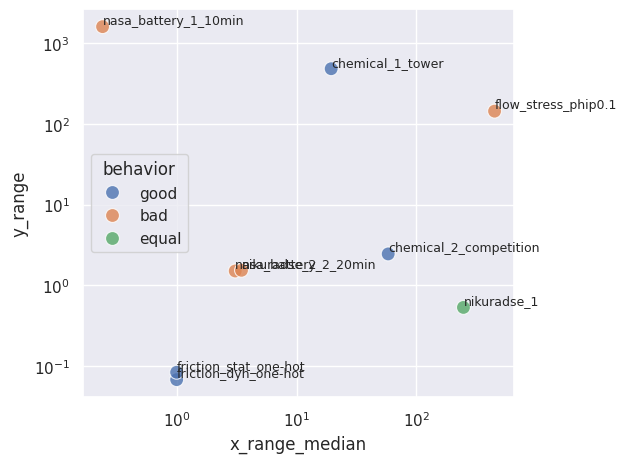

In [27]:
ax = sns.scatterplot(
    data=stats_df,
    x="x_range_median",
    y="y_range",
    hue="behavior",
    s=100,
    alpha=0.8
)
ax.set_xscale("log")
ax.set_yscale("log")
for _, row in stats_df.iterrows():
    ax.text(
        row["x_range_median"],
        row["y_range"],
        row["dataset"],
        fontsize=9,
        ha="left",
        va="bottom"
    )
plt.tight_layout()
plt.show()

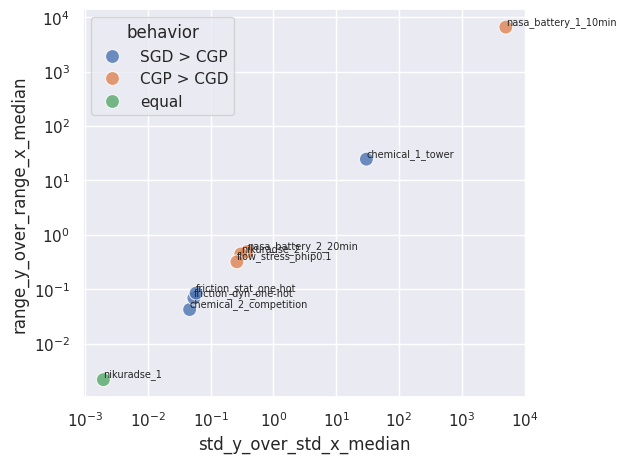

In [35]:
ax = sns.scatterplot(
    data=stats_df,
    x="std_y_over_std_x_median",
    y="range_y_over_range_x_median",
    hue="behavior",
    s=100,
    alpha=0.8
)
ax.set_xscale("log")
ax.set_yscale("log")
for _, row in stats_df.iterrows():
    ax.text(
        row["std_y_over_std_x_median"],
        row["range_y_over_range_x_median"],
        row["dataset"],
        fontsize=7,
        ha="left",
        va="bottom"
    )
plt.tight_layout()
plt.show()